In [33]:
%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits


Credit for template notebook: Sarik Jeram

# General process (Mercury)
 1) Process your data
 2) Identify known lines in your spectrum
 3) Create line list
 4) Fit polynomial to line list (+ examine residuals)
 5) Apply wavelength solution to data!

In [2]:
path = '/Users/chris/Desktop/uf_grad_school/obs_tech/spectroscopy-lab/'

In [3]:
dark0d1 = fits.getdata(path+'Pepito_lamp_spectra/dark_0d1s.FIT')
dark1 = fits.getdata(path+'Pepito_lamp_spectra/dark_1s.FIT')
dark2 = fits.getdata(path+'Pepito_lamp_spectra/dark_2s.FIT')

In [4]:
hg_spec = fits.getdata(path+'Pepito_lamp_spectra/mercury_0d1s.FIT')

In [5]:
hg_rect = hg_spec[364:434,:]

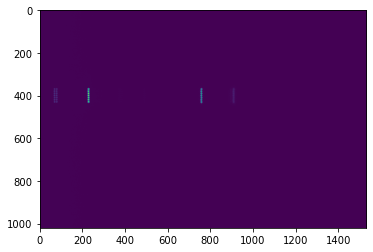

In [6]:
plt.figure()
plt.imshow(hg_spec)
plt.show()

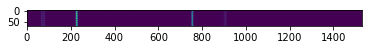

In [7]:
plt.figure()
plt.imshow(hg_rect)
plt.show()

In [8]:
hg_collapsed = np.median(hg_rect, axis=0)
detector_loc = np.arange(len(hg_collapsed))

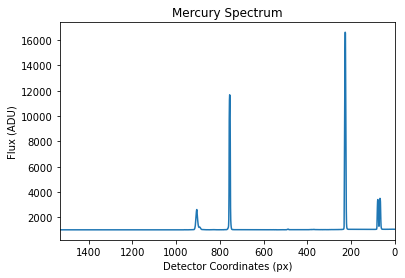

In [9]:
plt.figure()
plt.plot(detector_loc, hg_collapsed)
plt.xlim([1530, 0])
plt.xlabel('Detector Coordinates (px)')
plt.ylabel('Flux (ADU)')
plt.title('Mercury Spectrum')
plt.show()

In [10]:
def get_line_centroid(x_bounds, detector_px, flux):
    indcs = (detector_px > x_bounds[0]) & (detector_px < x_bounds[1])  # get the indices where we're in between the specified bounds
    x_i, m_i = detector_px[indcs], flux[indcs]  # apply the indices to our detector location and flux arrays
    return sum(x_i * m_i) / sum(m_i)  # return the centroid (flux weighted center-of-mass of the line)


print(f'{get_line_centroid([902, 908], detector_loc, hg_collapsed):.2f}')


905.04


In [ ]:
# Get lines from: https://physics.nist.gov/PhysRefData/Handbook/element_name.htm
# Generate a CSV file that includes thdetector location of the line as well as the wavelength you believe it is
# Use the centroiding function in the above cell instead of eye-ball estimates
"""
pepito_lines.csv:

lamp,wl_AA,loc_px
Hg,4046.563,905.1
Hg,4078,891.5
Hg,4358,754.5
Hg,5461,226.5
Hg,5770,77.6
Hg,5790,67.5
"""

In [18]:
line_data = np.genfromtxt('pepito_lines.csv', names=True, delimiter=',', dtype=float)  # load our file
#print(line_data[:-1])
line_data = line_data[:-1] # to account for adding H afterward
wavelengths, locations = line_data['wl_AA'], line_data['loc_px']
argsort = np.argsort(locations)  # sort the wavelengths by their detector locations to prevent issues later on
locations, wavelengths=locations[argsort], wavelengths[argsort]  # apply the sorted indices to the original arrays

In [19]:
print(locations)
print(wavelengths)

[ 67.5  77.6 226.5 754.5 891.5 905.1]
[5790.    5770.    5461.    4358.    4078.    4046.563]


In [20]:
coeffs = np.polyfit(locations, wavelengths, deg=5)  # determine coefficients for a polynomial of degree 5 to be fit to the data
print(coeffs)  # A*x^5 + B*x^4 + C*x^3 + D*x^2 + E*x + F; very small valued coefficients indicate you're probably over-fitting
polynomial = np.poly1d(coeffs)  # create a poly1d object from our coefficients for np.polyval to use
fitted_wavelengths = np.polyval(polynomial, locations)  # get the wavelength from the fit for the specified detector coordinates

[-3.02112276e-12  5.20752080e-09 -2.15503576e-06 -2.44411914e-04
 -1.91822010e+00  5.92115236e+03]


<IPython.core.display.Javascript object>


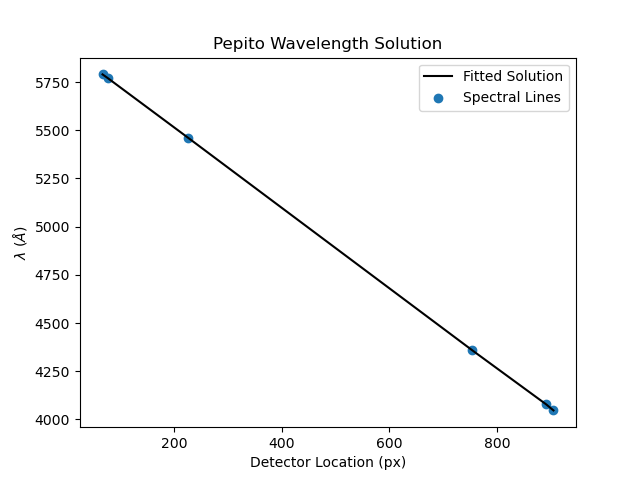

In [21]:
# Plot the fit
plt.figure()
plt.scatter(locations, wavelengths, label='Spectral Lines')
plt.plot(locations, fitted_wavelengths, c='k', label='Fitted Solution')
plt.xlabel('Detector Location (px)')
plt.ylabel(r'$\lambda$ ($\AA$)')
plt.title('Pepito Wavelength Solution')
plt.legend()
plt.show()


In [22]:
residuals = fitted_wavelengths - wavelengths
print(np.std(residuals)) # RMS of residuals

3.862379134031443e-12


In [42]:
# Plot the residuals
%matplotlib notebook
plt.figure()
plt.scatter(locations, residuals, label='Residuals')
plt.xlabel('Detector Location (px)')
plt.ylabel('Residual Value (AA)')
plt.ylim([-0.015, 0.015])
plt.show()

<IPython.core.display.Javascript object>

### Hydrogen

In [26]:
h_spec = fits.getdata(path+'Pepito_lamp_spectra/hydrogen_1s.FIT')

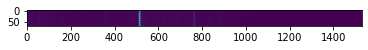

In [28]:
%matplotlib inline
#%matplotlib notebook
h_rect = h_spec[364:434,:]
plt.imshow(h_rect)
plt.show()

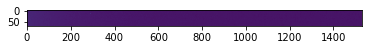

In [29]:
%matplotlib inline
d1_rect = dark1[364:434,:]
plt.imshow(d1_rect)
plt.show()

In [51]:
#h_collapsed = np.median(h_rect-d1_rect, axis=0) # median-combine dark-subtracted rectangle of interest into 1D
h_collapsed = np.median(h_rect, axis=0) - np.median(d1_rect, axis=0) # oops, first way leads to saturated lines??
detector_loc = np.arange(len(h_collapsed))

<IPython.core.display.Javascript object>


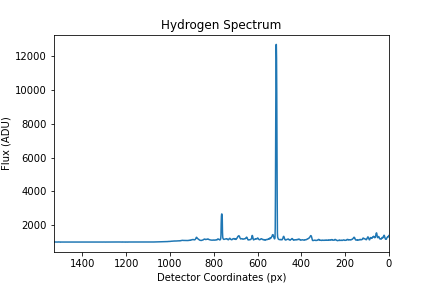

In [123]:
#%matplotlib notebook
plt.figure()
plt.plot(detector_loc, np.median(h_rect, axis=0)) # without dark subtraction
plt.xlim([1530, 0])
plt.xlabel('Detector Coordinates (px)')
plt.ylabel('Flux (ADU)')
plt.title('Hydrogen Spectrum')
plt.show()

<IPython.core.display.Javascript object>


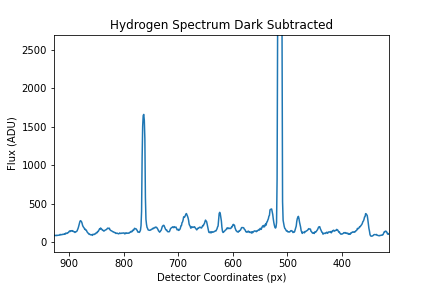

In [122]:
#%matplotlib notebook
plt.figure()
plt.plot(detector_loc, h_collapsed)
plt.xlim([1530, 0])
plt.xlabel('Detector Coordinates (px)')
plt.ylabel('Flux (ADU)')
plt.title('Hydrogen Spectrum Dark Subtracted')
plt.show()

In [55]:
print(f'{get_line_centroid([755, 770], detector_loc, h_collapsed):.2f}')

763.07


In [56]:
print(f'{get_line_centroid([505, 525], detector_loc, h_collapsed):.2f}')

514.09


In [57]:
# Estimate wavelength of observed emission line in Hydrogen spectrum using our current wavelength solution
# Useful for guessing which line you're looking at in one of the other lamp spectra
print(np.polyval(polynomial, 763))
print(np.polyval(polynomial, 514)) # um, the nearest wavelength per NIST is 4861.3615 AA

4341.690365922076
4833.061538175436


In [ ]:
# I only added the 763 position line; omitted the brighter line because the exercise asks for Ne
# and I'm not getting anything too close to NIST for it
"""
pepito_lines.csv:

lamp,wl_AA,loc_px
Hg,4046.563,905.1
Hg,4078,891.5
Hg,4358,754.5
Hg,5461,226.5
Hg,5770,77.6
Hg,5790,67.5
H,4340.462,762.8
"""

### Neon

In [40]:
ne_spec = fits.getdata(path+'Pepito_lamp_spectra/neon_2s.FIT')

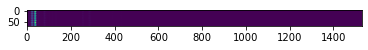

In [41]:
%matplotlib inline
#%matplotlib notebook
ne_rect = ne_spec[364:434,:]
plt.imshow(ne_rect)
plt.show()

In [44]:
dark2_rect = dark2[364:434,:]

In [125]:
#ne_collapsed = np.median(ne_rect-dark2_rect, axis=0) # leaves me with saturated lines again
ne_collapsed = np.median(ne_rect, axis=0) - np.median(dark2_rect, axis=0) 
detector_loc = np.arange(len(ne_collapsed))
print(ne_collapsed.shape, detector_loc.shape)

(1530,) (1530,)


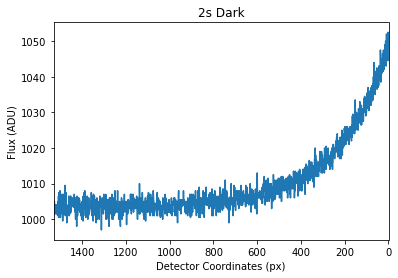

In [33]:
plt.figure()
plt.plot(detector_loc, np.median(dark2_rect, axis=0))
plt.xlim([1530, 0])
plt.xlabel('Detector Coordinates (px)')
plt.ylabel('Flux (ADU)')
plt.title('2s Dark')
plt.show()

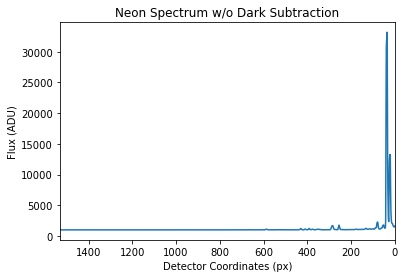

In [32]:
plt.figure()
plt.plot(detector_loc, np.median(ne_rect, axis=0))
plt.xlim([1530, 0])
plt.xlabel('Detector Coordinates (px)')
plt.ylabel('Flux (ADU)')
plt.title('Neon Spectrum w/o Dark Subtraction')
plt.show()

<IPython.core.display.Javascript object>


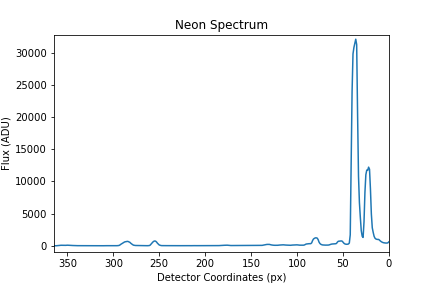

In [127]:
%matplotlib notebook
plt.figure()
plt.plot(detector_loc, ne_collapsed)
plt.xlim([1530, 0])
plt.xlabel('Detector Coordinates (px)')
plt.ylabel('Flux (ADU)')
plt.title('Neon Spectrum')
plt.show()

In [67]:
print(f'{get_line_centroid([17, 28], detector_loc, ne_collapsed):.2f}')
print(f'{get_line_centroid([30, 43], detector_loc, ne_collapsed):.2f}')
print(f'{get_line_centroid([46, 59], detector_loc, ne_collapsed):.2f}') # weak but might as well check
print(f'{get_line_centroid([75, 85], detector_loc, ne_collapsed):.2f}') # weak but might as well check
print(f'{get_line_centroid([248, 263], detector_loc, ne_collapsed):.2f}') # weak but might as well check
print(f'{get_line_centroid([276, 296], detector_loc, ne_collapsed):.2f}') # weak but might as well check
print(f'{get_line_centroid([347, 353], detector_loc, ne_collapsed):.2f}') # doublet?
print(f'{get_line_centroid([353, 360], detector_loc, ne_collapsed):.2f}') # doublet?
print(f'{get_line_centroid([363, 384], detector_loc, ne_collapsed):.2f}') # weak but might as well check
print(f'{get_line_centroid([384, 401], detector_loc, ne_collapsed):.2f}') # weak but might as well check
print(f'{get_line_centroid([401, 420], detector_loc, ne_collapsed):.2f}') # weak but might as well check
print(f'{get_line_centroid([420, 440], detector_loc, ne_collapsed):.2f}') # weak but might as well check
print(f'{get_line_centroid([578, 597], detector_loc, ne_collapsed):.2f}') # weak but might as well check

22.74
36.83
52.72
79.86
254.94
285.57
349.89
356.28
375.48
391.60
409.65
430.00
586.97


In [129]:
line_data = np.genfromtxt('pepito_lines.csv', names=True, delimiter=',', dtype=float)  # load our file
line_data = line_data[:-6] # Hg and H, no Ne (re-ran this after adding Ne)
wavelengths, locations = line_data['wl_AA'], line_data['loc_px']
argsort = np.argsort(locations)  # sort the wavelengths by their detector locations to prevent issues later on
locations, wavelengths=locations[argsort], wavelengths[argsort]  # apply the sorted indices to the original arrays
print(locations)
print(wavelengths)

[ 67.5  77.6 226.5 754.5 762.8 891.5 905.1]
[5790.    5770.    5461.    4358.    4340.462 4078.    4046.563]


In [130]:
coeffs = np.polyfit(locations, wavelengths, deg=5)  # determine coefficients for a polynomial of degree 5 to be fit to the data
print(coeffs)  # A*x^5 + B*x^4 + C*x^3 + D*x^2 + E*x + F; very small valued coefficients indicate you're probably over-fitting
polynomial = np.poly1d(coeffs)  # create a poly1d object from our coefficients for np.polyval to use
fitted_wavelengths = np.polyval(polynomial, locations)  # get the wavelength from the fit for the specified detector coordinates


[-2.76527794e-12  4.84931482e-09 -2.11298381e-06 -1.51861742e-04
 -1.94379155e+00  5.92250784e+03]


In [131]:
# Estimate wavelength of observed emission line in Neon spectrum using our updated wavelength solution
# Useful for guessing which line you're looking at in one of the other lamp spectra
print(np.polyval(polynomial, 22.74)) # y 5872.8275 or 5881.8952? the latter gives better fit
print(np.polyval(polynomial, 36.83)) # y 5852.4879
print(np.polyval(polynomial, 52.72)) # y 5820.1558
print(np.polyval(polynomial, 79.86)) # y 5764.4188
print(np.polyval(polynomial, 254.94)) # y 5400.5618
print(np.polyval(polynomial, 285.57)) # y 5330.7775
print(np.polyval(polynomial, 349.89)) # n
print(np.polyval(polynomial, 356.28)) # n
print(np.polyval(polynomial, 375.48)) # n? 5144.9384
print(np.polyval(polynomial, 391.60)) # n
print(np.polyval(polynomial, 409.65)) # n
print(np.polyval(polynomial, 430.00)) # n? 5005.1587
print(np.polyval(polynomial, 586.97)) # n

5878.203922769397
5850.615177447522
5819.335783295901
5765.420209834972
5399.5828064916805
5332.825482708056
5191.472093602388
5177.399135086012
5135.138200970852
5099.714813427641
5060.154705371413
5015.737736384503
4684.887096477927


In [ ]:
"""
lamp,wl_AA,loc_px
Hg,4046.563,905.1
Hg,4078,891.5
Hg,4358,754.5
Hg,5461,226.5
Hg,5770,77.6
Hg,5790,67.5
H,4340.462,762.8
Ne,5872.8275,22.74
Ne,5852.4879,36.83
Ne,5820.1558,52.72
Ne,5764.4188,79.86
Ne,5400.5618,254.94
Ne,5330.7775,285.57
"""

In [188]:
line_data = np.genfromtxt('pepito_lines.csv', names=True, delimiter=',', dtype=float)  # load our file
line_data = line_data[7:] # Ne only
wavelengths, locations = line_data['wl_AA'], line_data['loc_px']
argsort = np.argsort(locations)  # sort the wavelengths by their detector locations to prevent issues later on
locations, wavelengths=locations[argsort], wavelengths[argsort]  # apply the sorted indices to the original arrays

In [189]:
print(wavelengths)
print(locations)

[5881.8952 5852.4879 5820.1558 5764.4188 5400.5618 5330.7775]
[ 22.74  36.83  52.72  79.86 254.94 285.57]


In [190]:
coeffs = np.polyfit(locations, wavelengths, deg=5)  # determine coefficients for a polynomial of degree 5 to be fit to the data
print(coeffs)  # A*x^5 + B*x^4 + C*x^3 + D*x^2 + E*x + F; very small valued coefficients indicate you're probably over-fitting
polynomial = np.poly1d(coeffs)  # create a poly1d object from our coefficients for np.polyval to use
fitted_wavelengths = np.polyval(polynomial, locations)  # get the wavelength from the fit for the specified detector coordinates

[-7.29474131e-10  4.97297091e-07 -1.16346803e-04  1.09322277e-02
 -2.47522136e+00  5.93376818e+03]


<IPython.core.display.Javascript object>


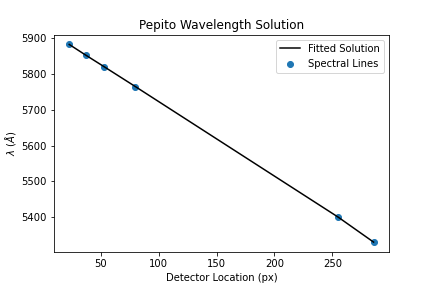

In [143]:
# Plot the fit
plt.figure()
plt.scatter(locations, wavelengths, label='Spectral Lines')
plt.plot(locations, fitted_wavelengths, c='k', label='Fitted Solution')
plt.xlabel('Detector Location (px)')
plt.ylabel(r'$\lambda$ ($\AA$)')
plt.title('Pepito Wavelength Solution')
plt.legend()
plt.show()


In [ ]:
"""# Extrapolate line to ends of spectrograph for kicks and wiggles
m = (wavelengths[5]-wavelengths[0])/(locations[5]-locations[0])
y1 = wavelengths[0] - (m * (locations[0]-0)) # lower bound of spectrograph
# never mind
"""

In [191]:
residuals = fitted_wavelengths - wavelengths
print(np.std(residuals)) # RMS of residuals

2.448889430131432e-12


<IPython.core.display.Javascript object>


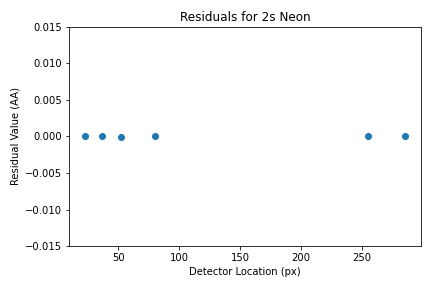

In [192]:
# Plot the residuals
%matplotlib notebook
plt.figure()
plt.scatter(locations, residuals, label='Residuals')
plt.xlabel('Detector Location (px)')
plt.ylabel('Residual Value (AA)')
plt.title('Residuals for 2s Neon')
plt.ylim([-0.015, 0.015])
plt.tight_layout()
plt.show()

#### Old Neon

Sarik took two sets of neon spectra: the one before and an older one. This is the latter.

In [86]:
ne_spec0d3 = fits.getdata(path+'Pepito_lamp_spectra/old_neon/neon_blue_0d3s.fit')
ne_spec10 = fits.getdata(path+'Pepito_lamp_spectra/old_neon/neon_red_10s.fit')
dark0d3 = fits.getdata(path+'Pepito_lamp_spectra/old_neon/dark_0d3s.FIT')
dark10 = fits.getdata(path+'Pepito_lamp_spectra/old_neon/dark_10s.FIT')

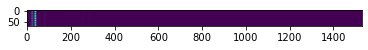

In [87]:
%matplotlib inline
ne_rect0d3 = ne_spec0d3[364:434,:]
dark_rect0d3 = dark0d3[364:434,:]
plt.imshow(ne_rect0d3)
plt.show()

##plt.imshow(ne_rect0d3-dark_rect0d3)
plt.show()

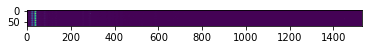

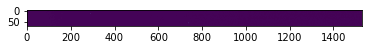

In [97]:
%matplotlib inline
ne_rect10 = ne_spec10[364:434,:]
dark_rect10 = dark10[364:434,:]

plt.imshow(ne_rect10)
plt.show()

plt.imshow(dark_rect10)
plt.show()

#plt.imshow(ne_rect10-dark_rect10)
#plt.show()

In [91]:
#ne_collapsed0d3 = np.median(ne_rect0d3-dark_rect0d3, axis=0)
ne_collapsed0d3 = np.median(ne_rect0d3, axis=0) - np.median(dark_rect0d3, axis=0)
detector_loc = np.arange(len(ne_collapsed0d3))

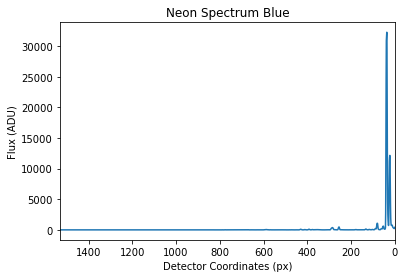

In [98]:
#%matplotlib notebook
plt.figure()
plt.plot(detector_loc, ne_collapsed0d3)
plt.xlim([1530, 0])
plt.xlabel('Detector Coordinates (px)')
plt.ylabel('Flux (ADU)')
plt.title('Neon Spectrum Blue')
plt.show()

In [93]:
ne_collapsed10 = np.median(ne_rect10, axis=0) - np.median(dark_rect10, axis=0)
detector_loc = np.arange(len(ne_collapsed10))

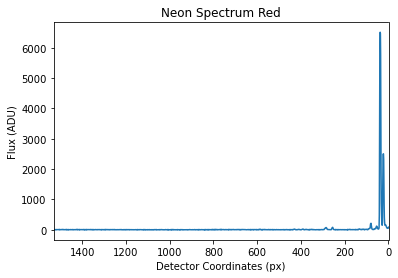

In [94]:
#%matplotlib notebook
plt.figure()
plt.plot(detector_loc, ne_collapsed10)
plt.xlim([1530, 0])
plt.xlabel('Detector Coordinates (px)')
plt.ylabel('Flux (ADU)')
plt.title('Neon Spectrum Red')
plt.show()

I already have higher wavelength lines and these don't give me any better lower wavelength lines.

By the way, this is what happens when I subtract and then median-combine.

In [158]:
ne_collapsed10 = np.median(ne_rect10-dark_rect10, axis=0)
detector_loc = np.arange(len(ne_collapsed10))

<IPython.core.display.Javascript object>


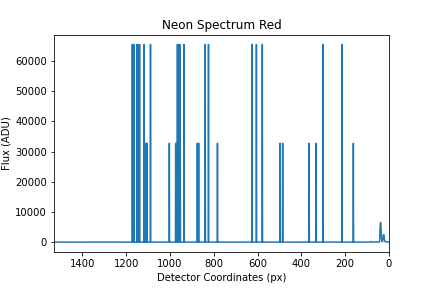

In [159]:
#%matplotlib notebook
plt.figure()
plt.plot(detector_loc, ne_collapsed10)
plt.xlim([1530, 0])
plt.xlabel('Detector Coordinates (px)')
plt.ylabel('Flux (ADU)')
plt.title('Neon Spectrum Red')
plt.show()

At this point, I learned that the lamp data for the spectroscopy project was way better, so let's try with that data instead.

### Neon using spectroscopy project data

In [148]:
import imageio # welcome to bmp file land
ne_lamp1 = imageio.imread(path+'pepito_star_spectra/ne_lamp_1s.bmp')
ne_lamp12 = imageio.imread(path+'pepito_star_spectra/ne_lamp_1s_2.bmp')
print(ne_lamp1)
print(ne_lamp12)
print(ne_lamp1.shape)
ne_lamp1s = np.median(np.array(np.stack((ne_lamp1, ne_lamp12))), axis=0) # stack the two images and take median
print(ne_lamp1s)
print(ne_lamp1s.shape)

[[45 47 44 ... 45 37 36]
 [42 38 44 ... 39 38 36]
 [46 49 39 ... 37 37 41]
 ...
 [39 31 33 ... 34 37 33]
 [40 33 31 ... 37 40 43]
 [36 38 33 ... 35 43 35]]
[[31 30 32 ... 33 27 25]
 [32 28 29 ... 25 28 21]
 [32 40 26 ... 22 25 22]
 ...
 [27 24 26 ... 22 26 26]
 [25 21 22 ... 21 30 32]
 [30 31 22 ... 27 29 26]]
(1200, 1600)
[[38.  38.5 38.  ... 39.  32.  30.5]
 [37.  33.  36.5 ... 32.  33.  28.5]
 [39.  44.5 32.5 ... 29.5 31.  31.5]
 ...
 [33.  27.5 29.5 ... 28.  31.5 29.5]
 [32.5 27.  26.5 ... 29.  35.  37.5]
 [33.  34.5 27.5 ... 31.  36.  30.5]]
(1200, 1600)


In [149]:
# now darks
dark11 = imageio.imread(path+'pepito_star_spectra/dark_1s_1.bmp')
dark12 = imageio.imread(path+'pepito_star_spectra/dark_1s_2.bmp')
dark13 = imageio.imread(path+'pepito_star_spectra/dark_1s_3.bmp')
dark_1s = np.median(np.array(np.stack((dark11, dark12, dark13))), axis=0)
print(dark_1s.shape)

(1200, 1600)


<IPython.core.display.Javascript object>


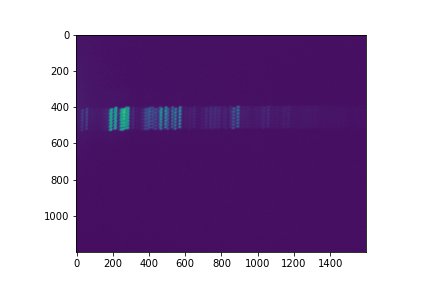

In [150]:
plt.figure()
plt.imshow(ne_lamp1s)
plt.show()

<IPython.core.display.Javascript object>


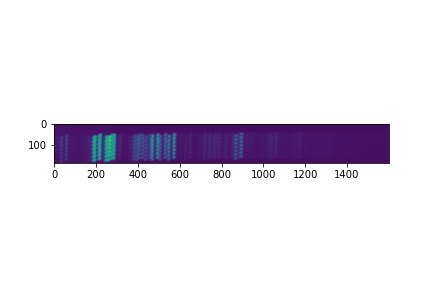

In [153]:
ne_rect1 = ne_lamp1s[355:539,:]
ne_rect11 = ne_lamp1[355:539,:]
ne_rect12 = ne_lamp12[355:539,:]
plt.figure()
plt.imshow(ne_rect1)
plt.show()

In [156]:
#ne_collapsed = np.median(ne_rect1-dark_rect1, axis=0)
ne_collapsed = np.median(ne_rect1, axis=0) - np.median(dark_rect1, axis=0)
ne_collapsed1 = np.median(ne_rect11, axis=0) - np.median(dark_rect1, axis=0)
ne_collapsed2 = np.median(ne_rect12, axis=0) - np.median(dark_rect1, axis=0)
detector_loc = np.arange(len(ne_collapsed))

<IPython.core.display.Javascript object>


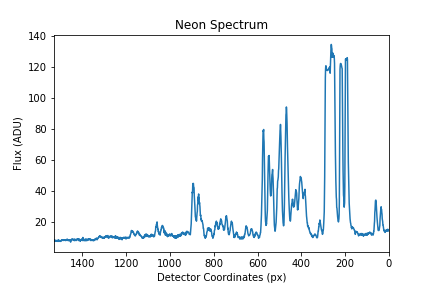

In [162]:
plt.figure()
plt.plot(detector_loc, ne_collapsed)
plt.xlim([1530, 0])
plt.xlabel('Detector Coordinates (px)')
plt.ylabel('Flux (ADU)')
plt.title('Neon Spectrum')
plt.show()

<IPython.core.display.Javascript object>


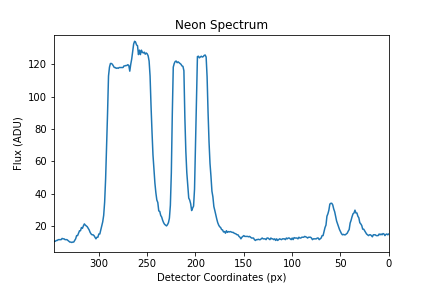

In [155]:
plt.figure()
plt.plot(detector_loc, ne_collapsed)
plt.xlim([1530, 0])
plt.xlabel('Detector Coordinates (px)')
plt.ylabel('Flux (ADU)')
plt.title('Neon Spectrum')
plt.show()

<IPython.core.display.Javascript object>


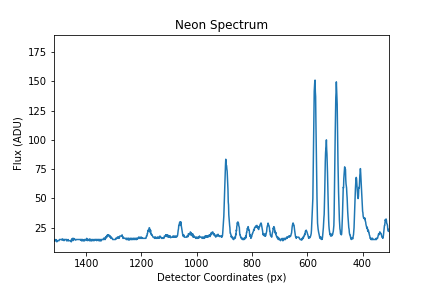

In [157]:
# how about first frame by itself
plt.figure()
plt.plot(detector_loc, ne_collapsed1)
plt.xlim([1530, 0])
plt.xlabel('Detector Coordinates (px)')
plt.ylabel('Flux (ADU)')
plt.title('Neon Spectrum')
plt.show()

<IPython.core.display.Javascript object>


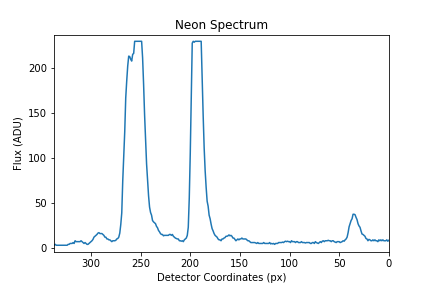

In [158]:
# vs second frame by itself
plt.figure()
plt.plot(detector_loc, ne_collapsed2)
plt.xlim([1530, 0])
plt.xlabel('Detector Coordinates (px)')
plt.ylabel('Flux (ADU)')
plt.title('Neon Spectrum')
plt.show()

I don't think the two science frames are well-aligned, and I don't know yet which one is closer to the NIST values, so I don't know which one to shift. It might just be better to go off one dark-subtracted image, whichever is closest to NIST.

<IPython.core.display.Javascript object>


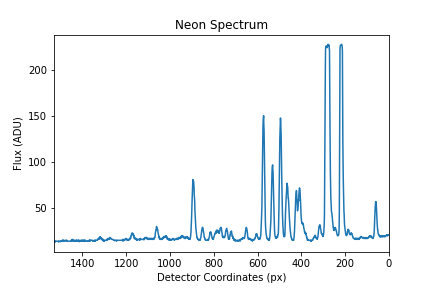

In [250]:
# ne lamp 1s
plt.figure()
#ne_rect1_dark = np.median(ne_lamp1[355:539,:]-dark_rect1, axis=0)
plt.plot(detector_loc, ne_collapsed1)
plt.xlim([1530, 0])
plt.xlabel('Detector Coordinates (px)')
plt.ylabel('Flux (ADU)')
plt.title('Neon Spectrum')
plt.show()

In [234]:
print(f'{get_line_centroid([50, 70], detector_loc, ne_rect1_dark):.2f}') # rightmost line
print(f'{get_line_centroid([200, 230], detector_loc, ne_rect1_dark):.2f}') # big ol line
print(f'{get_line_centroid([260, 297], detector_loc, ne_rect1_dark):.2f}') # other big ol line
print(f'{get_line_centroid([403, 417], detector_loc, ne_rect1_dark):.2f}') # doublet 
print(f'{get_line_centroid([417, 428], detector_loc, ne_rect1_dark):.2f}') # doublet
print(f'{get_line_centroid([450, 477], detector_loc, ne_rect1_dark):.2f}')
print(f'{get_line_centroid([480, 508], detector_loc, ne_rect1_dark):.2f}')
print(f'{get_line_centroid([519, 545], detector_loc, ne_rect1_dark):.2f}')
print(f'{get_line_centroid([559, 587], detector_loc, ne_rect1_dark):.2f}')
print(f'{get_line_centroid([878, 905], detector_loc, ne_rect1_dark):.2f}')
print(f'{get_line_centroid([1045, 1079], detector_loc, ne_rect1_dark):.2f}')


59.52
216.28
279.33
409.68
422.49
463.36
494.22
531.57
572.77
892.29
1061.50


In [238]:
# Estimate wavelength for easier identification in NIST
print(np.polyval(polynomial, 59.52)) # y 5804.4496
print(np.polyval(polynomial, 216.28)) # n 
print(np.polyval(polynomial, 279.33)) # y 5343.2834 or 5341.0938?
print(np.polyval(polynomial, 409.68)) # n 
print(np.polyval(polynomial, 422.49)) # y 5037.7512
print(np.polyval(polynomial, 463.36)) # n 
print(np.polyval(polynomial, 494.22)) # y? 4884.9170
print(np.polyval(polynomial, 531.57)) # y? 4790.2195 or 4788.9258?
print(np.polyval(polynomial, 572.77)) # y 4712.0633 or 4715.344?
print(np.polyval(polynomial, 892.29)) # n
print(np.polyval(polynomial, 1061.50)) # y 3593.5257


5805.888631481503
5482.926136566432
5346.467308970244
5060.08906912945
5032.103232086043
4943.492721036641
4877.460257583969
4798.779588932935
4713.749364835807
4075.9451311546295
3590.8140708589785


<IPython.core.display.Javascript object>


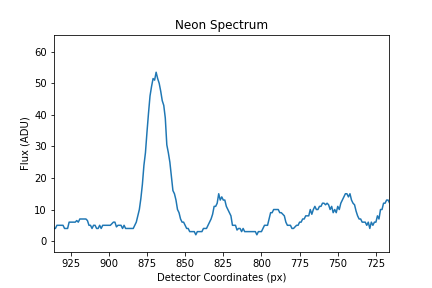

In [213]:
# ne lamp 1s second take
plt.figure()
#ne_rect12_dark = np.median(ne_lamp12[355:539,:]-dark_rect1, axis=0)
plt.plot(detector_loc, ne_collapsed2)
plt.xlim([1530, 0])
plt.xlabel('Detector Coordinates (px)')
plt.ylabel('Flux (ADU)')
plt.title('Neon Spectrum')
plt.show()

In [224]:
print(f'{get_line_centroid([24.5, 46], detector_loc, ne_rect1_dark):.2f}') # rightmost line
print(f'{get_line_centroid([177, 203], detector_loc, ne_rect1_dark):.2f}') # big ol line
print(f'{get_line_centroid([237, 271], detector_loc, ne_rect1_dark):.2f}') # other big ol line
print(f'{get_line_centroid([379, 391], detector_loc, ne_rect1_dark):.2f}') # doublet 
print(f'{get_line_centroid([391, 405], detector_loc, ne_rect1_dark):.2f}') # doublet
print(f'{get_line_centroid([423, 455], detector_loc, ne_rect1_dark):.2f}')
print(f'{get_line_centroid([455, 486], detector_loc, ne_rect1_dark):.2f}')
print(f'{get_line_centroid([496, 522], detector_loc, ne_rect1_dark):.2f}')
print(f'{get_line_centroid([536, 565], detector_loc, ne_rect1_dark):.2f}')
print(f'{get_line_centroid([851, 885], detector_loc, ne_rect1_dark):.2f}')


35.07
190.27
259.45
385.34
398.74
436.68
467.45
504.02
549.31
868.49


In [225]:
# Estimate wavelength for easier identification in NIST
print(np.polyval(polynomial, 35.07)) # y 5852.4879
print(np.polyval(polynomial, 190.27)) # n
print(np.polyval(polynomial, 259.45)) # n
print(np.polyval(polynomial, 385.34)) # n
print(np.polyval(polynomial, 398.74)) # n
print(np.polyval(polynomial, 436.68)) # y 5005.1587
print(np.polyval(polynomial, 467.45)) # n
print(np.polyval(polynomial, 504.02)) # n
print(np.polyval(polynomial, 549.31)) # y? 4752.7320
print(np.polyval(polynomial, 868.49)) # n 

5854.068342973601
5538.276075639834
5389.788397836066
5113.462459045553
5084.050678031792
5001.209631758886
4934.693234713482
4856.677022881215
4761.933177413039
4128.195590085632


First frame wins. Let's adjust the second frame to align with the first.

In [167]:
ne2 = list(ne_collapsed2)
for i in range(25):
    ne2.insert(0,ne2.pop())
print(ne2[0:10])
ne2[0:25] = np.zeros(25)
print(ne2[0:10])

[1.0, 1.5, 2.0, 2.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [181]:
print(ne_collapsed1)
print(np.array(ne2))
print((ne_collapsed1 + np.array(ne2))/2)

[21. 21. 22. ... 14. 14. 13.]
[0. 0. 0. ... 2. 1. 2.]
[10.5 10.5 11.  ...  8.   7.5  7.5]


<IPython.core.display.Javascript object>


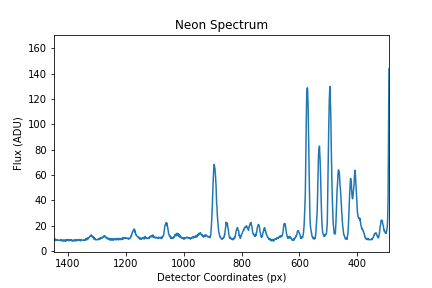

In [180]:
# mean of first and adjusted second dark-subtracted frames 
plt.figure()
plt.plot(detector_loc, (ne_collapsed1 + np.array(ne2))/2)
plt.xlim([1530, 0])
plt.xlabel('Detector Coordinates (px)')
plt.ylabel('Flux (ADU)')
plt.title('Neon Spectrum')
plt.show()

The only thing this could possibly add though is lines that didn't stand out before. Comparing this to the first of the 1s neon frames, there's not really anything new.

In [194]:
# this time using neon lines from the star spectroscopy project
line_data = np.genfromtxt(path+'pepito_star_spectra/pepito_lines.csv', names=True, delimiter=',', dtype=float)  # load our file
wavelengths, locations = line_data['wl_AA'], line_data['loc_px']
argsort = np.argsort(locations)  # sort the wavelengths by their detector locations to prevent issues later on
locations, wavelengths=locations[argsort], wavelengths[argsort]  # apply the sorted indices to the original arrays
print(locations)
print(wavelengths)


[  59.52  279.33  422.49  494.22  531.57  572.77 1061.5 ]
[5804.4496 5343.2834 5037.7512 4884.917  4790.2195 4712.0633 3593.5257]


In [195]:
coeffs = np.polyfit(locations, wavelengths, deg=5)  # determine coefficients for a polynomial of degree 5 to be fit to the data
print(coeffs)  # A*x^5 + B*x^4 + C*x^3 + D*x^2 + E*x + F; very small valued coefficients indicate you're probably over-fitting
polynomial = np.poly1d(coeffs)  # create a poly1d object from our coefficients for np.polyval to use
fitted_wavelengths = np.polyval(polynomial, locations)  # get the wavelength from the fit for the specified detector coordinates


[-1.72786602e-11  4.18751732e-08 -3.57660184e-05  1.31315131e-02
 -4.06026823e+00  6.00663380e+03]


<IPython.core.display.Javascript object>


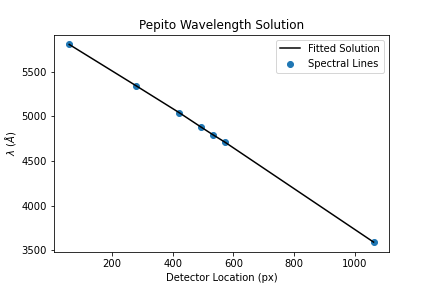

In [196]:
# Plot the fit
plt.figure()
plt.scatter(locations, wavelengths, label='Spectral Lines')
plt.plot(locations, fitted_wavelengths, c='k', label='Fitted Solution')
plt.xlabel('Detector Location (px)')
plt.ylabel(r'$\lambda$ ($\AA$)')
plt.title('Pepito Wavelength Solution')
plt.legend()
plt.show()

In [197]:
residuals = fitted_wavelengths - wavelengths
print(np.std(residuals)) # RMS of residuals

3.55870371719123


<IPython.core.display.Javascript object>


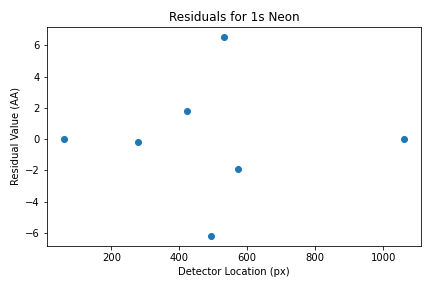

In [199]:
plt.figure()
plt.scatter(locations, residuals, label='Residuals')
plt.xlabel('Detector Location (px)')
plt.ylabel('Residual Value (AA)')
plt.title('Residuals for 1s Neon')
#plt.ylim([-0.015, 0.015])
plt.tight_layout()
plt.show()

Not great RMS. Let's drop the seventh line and see how much better the fit gets.

In [200]:
# this time using neon lines from the star spectroscopy project
line_data = np.genfromtxt(path+'pepito_star_spectra/pepito_lines.csv', names=True, delimiter=',', dtype=float)  # load our file
line_data = line_data[:-1] # retroactive exclusion of shortest wavelength b/c it throws off the fit
wavelengths, locations = line_data['wl_AA'], line_data['loc_px']
argsort = np.argsort(locations)  # sort the wavelengths by their detector locations to prevent issues later on
locations, wavelengths=locations[argsort], wavelengths[argsort]  # apply the sorted indices to the original arrays
print(locations)
print(wavelengths)


[ 59.52 279.33 422.49 494.22 531.57 572.77]
[5804.4496 5343.2834 5037.7512 4884.917  4790.2195 4712.0633]


In [201]:
coeffs = np.polyfit(locations, wavelengths, deg=5)  # determine coefficients for a polynomial of degree 5 to be fit to the data
print(coeffs)  # A*x^5 + B*x^4 + C*x^3 + D*x^2 + E*x + F; very small valued coefficients indicate you're probably over-fitting
polynomial = np.poly1d(coeffs)  # create a poly1d object from our coefficients for np.polyval to use
fitted_wavelengths = np.polyval(polynomial, locations)  # get the wavelength from the fit for the specified detector coordinates


[ 6.83202844e-10 -1.25283585e-06  8.62490328e-04 -2.70814279e-01
  3.43206137e+01  4.55443217e+03]


<IPython.core.display.Javascript object>


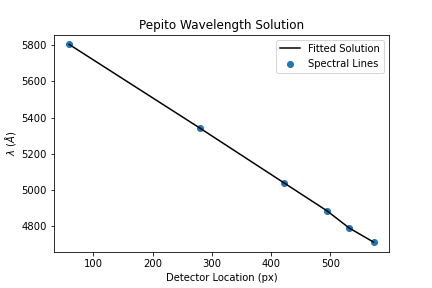

In [202]:
# Plot the fit
plt.figure()
plt.scatter(locations, wavelengths, label='Spectral Lines')
plt.plot(locations, fitted_wavelengths, c='k', label='Fitted Solution')
plt.xlabel('Detector Location (px)')
plt.ylabel(r'$\lambda$ ($\AA$)')
plt.title('Pepito Wavelength Solution')
plt.legend()
plt.show()

In [203]:
residuals = fitted_wavelengths - wavelengths
print(np.std(residuals)) # RMS of residuals

1.4384367880947875e-11


<IPython.core.display.Javascript object>


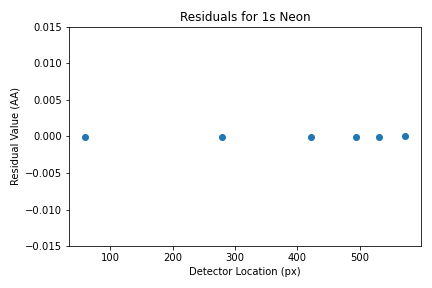

In [205]:
plt.figure()
plt.scatter(locations, residuals, label='Residuals')
plt.xlabel('Detector Location (px)')
plt.ylabel('Residual Value (AA)')
plt.title('Residuals for 1s Neon')
plt.ylim([-0.015, 0.015])
plt.tight_layout()
plt.show()

Much better! What if we put this together with the 2s neon fit?

In [ ]:
"""
lamp,wl_AA,loc_px
Ne,5881.8952,22.74
Ne,5852.4879,36.83
Ne,5820.1558,52.72
Ne,5764.4188,79.86
Ne,5400.5618,254.94
Ne,5330.7775,285.57
Ne,5804.4496,59.52
Ne,5343.2834,279.33
Ne,5037.7512,422.49
Ne,4884.9170,494.22
Ne,4790.2195,531.57
Ne,4712.0633,572.77
"""

In [207]:
# this time using neon lines from the star spectroscopy project
line_data = np.genfromtxt(path+'neon_lines.csv', names=True, delimiter=',', dtype=float)  # load our file
wavelengths, locations = line_data['wl_AA'], line_data['loc_px']
argsort = np.argsort(locations)  # sort the wavelengths by their detector locations to prevent issues later on
locations, wavelengths=locations[argsort], wavelengths[argsort]  # apply the sorted indices to the original arrays
print(locations)
print(wavelengths)


[ 22.74  36.83  52.72  59.52  79.86 254.94 279.33 285.57 422.49 494.22
 531.57 572.77]
[5881.8952 5852.4879 5820.1558 5804.4496 5764.4188 5400.5618 5343.2834
 5330.7775 5037.7512 4884.917  4790.2195 4712.0633]


In [208]:
coeffs = np.polyfit(locations, wavelengths, deg=5)  # determine coefficients for a polynomial of degree 5 to be fit to the data
print(coeffs)  # A*x^5 + B*x^4 + C*x^3 + D*x^2 + E*x + F; very small valued coefficients indicate you're probably over-fitting
polynomial = np.poly1d(coeffs)  # create a poly1d object from our coefficients for np.polyval to use
fitted_wavelengths = np.polyval(polynomial, locations)  # get the wavelength from the fit for the specified detector coordinates


[ 1.55376820e-11 -2.13809586e-08  1.01295097e-05 -2.05974143e-03
 -1.92033555e+00  5.92576304e+03]


<IPython.core.display.Javascript object>


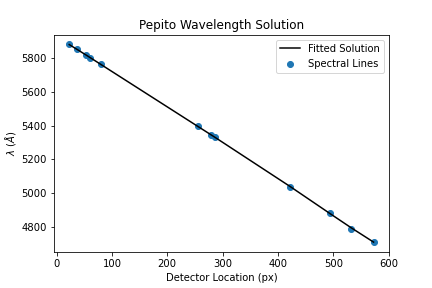

In [209]:
# Plot the fit
plt.figure()
plt.scatter(locations, wavelengths, label='Spectral Lines')
plt.plot(locations, fitted_wavelengths, c='k', label='Fitted Solution')
plt.xlabel('Detector Location (px)')
plt.ylabel(r'$\lambda$ ($\AA$)')
plt.title('Pepito Wavelength Solution')
plt.legend()
plt.show()

In [210]:
residuals = fitted_wavelengths - wavelengths
print(np.std(residuals)) # RMS of residuals

3.05305083208792


<IPython.core.display.Javascript object>


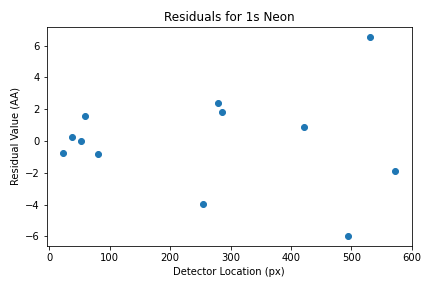

In [211]:
plt.figure()
plt.scatter(locations, residuals, label='Residuals')
plt.xlabel('Detector Location (px)')
plt.ylabel('Residual Value (AA)')
plt.title('Residuals for 1s Neon')
plt.tight_layout()
plt.show()

Interesting, it's worse than 1s or 2s neon alone. 